# make a new function to make a 2D slice based on 1D Earth model (or 2D or 3D)

In [1]:
# Nobuaki Fuji Oct 2025

# breaking news! confirmed by Lorette and Stéphanie, the CMB is ellipsoidal! 
# when working with geodetic earth models, r_PREM should be corrected as a function of latitude!

using Pkg


cd(@__DIR__)
Pkg.activate("../..")
ParamFile = "../test/testparam.csv"
include("../src/batchRevise.jl") 

myInclude("../src/DSM1D.jl")
using .DSM1D

  Activating project at `~/Documents/Github/flexibleDSM`
┌ Info: Including with Revise: ../src/DSM1D.jl
└ @ Main /Users/nobuaki/Documents/Github/flexibleDSM/OPTmotors/src/batchRevise.jl:25


  0.004269 seconds (2.17 k allocations: 108.156 KiB, 90.99% compilation time)


In [2]:
using Geodesy, Interpolations, StaticArrays, GMT, LinearAlgebra

In [6]:
import Base: +,-,/
struct GeoPoint
    lat::Float64 # in degree
    lon::Float64 # in degree
    alt::Float64 # in metre
    ecef::SVector{3,Float64}
    radius::Float64 # in metre
    #effectiveRadius::Float64 # in metre (useful to get values from 1D averaged model)
end

struct localCoord2D
    ix::Int64
    iz::Int64
    x::Float64
    z::Float64
    horizontalVector::SVector{2,Float64}
    normalVector::SVector{2,Float64}
end

struct localCoord3D
    ix::Int64
    iy::Int64
    iz::Int64
    x::Float64
    y::Float64
    z::Float64
    horizontalVector1::SVector{3,Float64}
    horizontalVector2::SVector{3,Float64}
    normalVector::SVector{3,Float64}
end

function localCoord2D(ix,iz,x,z)
    localCoord2D(ix,iz,x,z,(0.0,0.0),(0.0,0.0))
end

function GeoPoint(lat::Float64, lon::Float64; alt=0.0, ell=wgs84)
    lla = LLA(lat,lon, alt) # be careful LLA uses degrees by default!!
    ecef_coords = ECEF(lla,ell)
    radius = norm([ecef_coords.x,ecef_coords.y,ecef_coords.z])
    GeoPoint(lat, lon, alt, SVector(ecef_coords.x, ecef_coords.y, ecef_coords.z),radius)
end


function GeoPoint(ecef::SVector{3,Float64}; ell=wgs84)
    lla = LLA(ECEF(ecef...),ell)
    radius = norm(ecef)
    GeoPoint(lla.lat,lla.lon,lla.alt,ecef,radius)
end

function +(a::GeoPoint,b::GeoPoint; ell=wgs84)
    ecef=a.ecef + b.ecef
    lla = LLA(ECEF(ecef...),ell)
    radius = norm(ecef)
    GeoPoint(lla.lat,lla.lon,lla.alt,ecef,radius)
end

function -(a::GeoPoint,b::GeoPoint; ell=wgs84)
    ecef=a.ecef - b.ecef
    lla = LLA(ECEF(ecef...),ell)
    radius = norm(ecef)
    GeoPoint(lla.lat,lla.lon,lla.alt,ecef,radius)
end

function /(a::GeoPoint,c::Real; ell=wgs84)
    ecef=a.ecef / c
    lla = LLA(ECEF(ecef...),ell)
    radius = norm(ecef)
    GeoPoint(lla.lat,lla.lon,lla.alt,ecef,radius)
end


function effectiveRadius(a::GeoPoint,r0::Float64; ell=wgs84)
    radiusPlanetHere = GeoPoint(a.lat,a.lon).radius 
    ratio = r0/radiusPlanetHere
    return a.radius*ratio
end




effectiveRadius (generic function with 1 method)

In [ ]:
# Example 1-D model (toy). Replace with your actual model arrays.
# r_model in meters from Earth center (0..R_ref), assume sorted ascending
R_ref = DSM1D.my1DDSMmodel.averagedPlanetRadiusInKilometer*1.e3                   # model reference radius (m)


6.371e6

In [5]:
# create an interpolator in radius space (ensure interpolation domain covers used r)
#r_model = collect(0.0:1000.0:R_ref)  # example radius grid
#v_model = 5000 .- 0.5 .* (R_ref .- r_model) ./ 1000;  # dummy profile
#itp = LinearInterpolation(r_model, v_model; extrapolation_bc=Flat())

In [7]:
p1 = GeoPoint(48.8566,2.3522) # Paris
p2 = GeoPoint(42.8,1.5) # Tarascon (à peu près)
#topographyFromGeoPoint(p1)
@show GeoPoint(p1.ecef)
@show p0 = (p1 + p2)/2.0


GeoPoint(p1.ecef) = GeoPoint(48.8566, 2.3522000000000003, 7.047140324999535e-10, [4.200914795649138e6, 172559.77631070156, 4.780081341967356e6], 6.366053693814456e6)
p0 = (p1 + p2) / 2.0 = GeoPoint(45.82989800475024, 1.9029714540760907, -8978.352692728113, [4.443193158578102e6, 147626.58304377226, 4.545653677986095e6], 6.358201507709939e6)


GeoPoint(45.82989800475024, 1.9029714540760907, -8978.352692728113, [4.443193158578102e6, 147626.58304377226, 4.545653677986095e6], 6.358201507709939e6)

In [8]:
# pre-definition of x-axis vector p1->p2 (normally this is not the one we want)
p2_1 = p2-p1
x_axis_tentative = (p2_1/p2_1.radius).ecef


3-element SVector{3, Float64} with indices SOneTo(3):
  0.7166970175507206
 -0.07375625720924696
 -0.693473431038555

In [9]:
# definition of z-axis vector centre -> p0

z_axis = (p0/p0.radius).ecef

3-element SVector{3, Float64} with indices SOneTo(3):
 0.698812888076966
 0.023218292604404035
 0.7149275895823759

In [10]:
# y-axis: complete right-handed system
y_axis = normalize(cross(z_axis, x_axis_tentative))

3-element SVector{3, Float64} with indices SOneTo(3):
  0.036629318622305354
  0.9970002078796852
 -0.06818268478968828

In [11]:
x_axis = cross(y_axis, z_axis)  # now perfectly orthogonal

3-element SVector{3, Float64} with indices SOneTo(3):
  0.7143660409585519
 -0.07383424934541309
 -0.6958661244440657

In [12]:
#Rotation matrix
R = SMatrix{3,3,Float64}(
    x_axis[1], x_axis[2], x_axis[3],
    y_axis[1], y_axis[2], y_axis[3],
    z_axis[1], z_axis[2], z_axis[3]
)

3×3 SMatrix{3, 3, Float64, 9} with indices SOneTo(3)×SOneTo(3):
  0.714366    0.0366293  0.698813
 -0.0738342   0.997      0.0232183
 -0.695866   -0.0681827  0.714928

In [13]:
p_2D_to_ECEF(x_2D,z_2D,pOrigin::SVector{3,Float64},R::SMatrix{3,3,Float64}) = pOrigin+R*SVector(x_2D,0.e0,z_2D)

p_2D_to_ECEF (generic function with 1 method)

In [14]:
p_ECEF_to_2D(p_3D::SVector{3,Float64},pOrigin::SVector{3,Float64},R::SMatrix{3,3,Float64}) = R' * (p_3D - pOrigin)

p_ECEF_to_2D (generic function with 1 method)

In [15]:
p_ECEF_to_2D(p0.ecef, p1.ecef,R)

3-element SVector{3, Float64} with indices SOneTo(3):
 338046.62854124676
     -2.8438589548976056e-11
   1129.5315985638524

In [19]:
p0.ecef - p_2D_to_ECEF(p_ECEF_to_2D(p0.ecef,p1.ecef,R)[1],p_ECEF_to_2D(p0.ecef,p1.ecef,R)[3],p1.ecef,R)

3-element SVector{3, Float64} with indices SOneTo(3):
  0.0
 -2.9103830456733704e-11
  0.0

In [16]:
p0_0_above=p_2D_to_ECEF(0,0,p1.ecef,R)

3-element SVector{3, Float64} with indices SOneTo(3):
      4.200914795649138e6
 172559.77631070156
      4.780081341967356e6

In [17]:
p0_1m_above=p_2D_to_ECEF(0,1,p1.ecef,R)

3-element SVector{3, Float64} with indices SOneTo(3):
      4.200915494462026e6
 172559.79952899416
      4.780082056894946e6

In [20]:
p_ECEF_to_2D(p0_1m_above, p1.ecef,R)

3-element SVector{3, Float64} with indices SOneTo(3):
 -8.852265046769912e-12
 -5.413994677125502e-12
  0.9999999999047554

In [116]:
Δx = 500 # in metre
Δz = 500

altMax = 5000 # in metre
altMin = -400.e3 # in metre
#altMin = -5000

# since p1 and p2 can be even out of the solid Earth or inside the Earth
# I define that p1 and p2 should be the left and right limits

leftLimit = 0 # in metre so x is always non-negative
rightLimit = p2_1.radius


676097.0312306838

In [117]:
@show Nx = Int64((rightLimit-leftLimit) ÷ Δx+1) 
@show Nz = Int64((altMax-altMin) ÷ Δz + 1 ) 

Nx = Int64((rightLimit - leftLimit) ÷ Δx + 1) = 1353
Nz = Int64((altMax - altMin) ÷ Δz + 1) = 811


811

In [118]:
allGridsInGeoPoints=Array{GeoPoint,2}(undef,Nx,Nz)

effectiveRadii=Array{Float64,2}(undef,Nx,Nz)

allGridsInCartesian2D=Array{localCoord2D,2}(undef,Nx,Nz)

seismicModel2D=(ρ=zeros(Float64,Nx,Nz),Vpv=zeros(Float64,Nx,Nz),Vph=zeros(Float64,Nx,Nz),Vsv=zeros(Float64,Nx,Nz),Vsh=zeros(Float64,Nx,Nz),Qμ=zeros(Float64,Nx,Nz),Qκ=zeros(Float64,Nx,Nz),QμPower=zeros(Float64,Nx,Nz),QκPower=zeros(Float64,Nx,Nz),η=zeros(Float64,Nx,Nz))

for iXZ in CartesianIndices(allGridsInGeoPoints)
    ix, iz = Tuple(iXZ)
    x = leftLimit+(ix-1)*Δx
    z = altMin+(iz-1)*Δz 
    tmpGeoPoint=GeoPoint(p_2D_to_ECEF(x,z,p1.ecef,R))
    
    allGridsInGeoPoints[iXZ]=tmpGeoPoint

    allGridsInCartesian2D[iXZ]=localCoord2D(ix,iz,x,z)
  
    effectiveRadii[iXZ]=effectiveRadius(tmpGeoPoint,DSM1D.my1DDSMmodel.averagedPlanetRadiusInKilometer*1.e3 )
end


In [119]:
DSM1D.my1DDSMmodel.C_Qκ

12×4 Matrix{Float64}:
  1327.7  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0

# about effectiveRadii corrections

In fact, there are three types of parameter modification, based on 1D planet models. 

(i) Changing effectiveRadii by the function effectiveRadius, considering the ellipticity of the planet (which is done above).

(ii) changing a topography of discontinuity (CMB, 410 or 660-km, solid-air surface), which can be further be done by changing effectiveRadii locally.

(iii) introducing a new layer (ocean or something that could exist only at some region in terms of lat and lon).


Reading the topo file can give the solid-air surface (option ii) and solid-liquid surface (option iii) so we need to separate the two of them.


The idea is to read topo for (ii) and (iii) and provide a interpolator for effectiveRadii first. Then (iii) can be done by overwriting the params matrix.

In [120]:
# now I need to use GMT.jl to get the topography

lats = [p.lat for p in allGridsInGeoPoints]
lons = [p.lon for p in allGridsInGeoPoints]

lat_min, lat_max = extrema(lats)
lon_min, lon_max = extrema(lons)
if lat_min === lat_max
    if lat_min > 1.0
        lat_min = lat_min - 0.5
    else
        lat_max = lat_max + 0.5
    end
end

if lon_min === lon_max
    if lon_min > 1.0
        lon_min = lon_min - 0.5
    else
        lon_max = lon_max + 0.5
    end
end

lat_min, lat_max,lon_min,lon_max

(42.60952377524328, 49.07203149611877, 1.4743871429132926, 2.3842115926789575)

In [121]:


using GMT,CairoMakie

#region = [lon_min, lon_max, lat_min, lat_max]
region = [-10,20,35,60]
precision = "@earth_relief_01m"
# resolution can be @earth_relief_01m (≈2 km), @earth_relief_03m, or coarser like 10m, 30m, etc.
topoEuro = GMT.grdcut(precision, region=region)

topoEuro_surface = copy(topoEuro.z)
topoEuro_bathymetry = copy(topoEuro.z)


1501×1801 Matrix{Float32}:
 -4274.0  -4272.0  -4269.5  -4269.5  …  -3032.0  -3012.5  -3003.5  -2986.5
 -4274.0  -4268.5  -4266.0  -4266.0     -3022.0  -2999.0  -3003.0  -3000.0
 -4270.0  -4265.0  -4261.5  -4261.5     -3023.5  -3000.0  -2997.0  -3001.5
 -4263.5  -4263.0  -4260.5  -4261.5     -3002.0  -2988.5  -2983.0  -2989.5
 -4250.5  -4258.5  -4260.0  -4263.0     -2969.5  -2966.5  -2982.5  -2990.5
 -4233.5  -4250.0  -4257.0  -4262.5  …  -2955.5  -2946.0  -2965.5  -2983.0
 -4179.0  -4199.5  -4226.0  -4249.0     -2962.0  -2942.0  -2972.5  -2997.0
 -4086.0  -4093.5  -4121.5  -4155.5     -2974.5  -2969.5  -3004.5  -2995.5
 -4012.0  -3997.0  -3990.5  -4023.0     -2969.5  -2985.5  -2992.5  -2960.0
 -3968.5  -3934.5  -3911.0  -3915.0     -2972.0  -2972.0  -2974.0  -2952.0
     ⋮                               ⋱                                 ⋮
 -1140.5  -1119.0  -1127.0  -1151.0       -89.5    -42.0    -42.5    -58.5
 -1160.5  -1156.0  -1159.5  -1167.0      -141.0    -98.0    -98.5   -111.0


In [122]:
topo_surface[topo_surface .< 0.0 ] .= 0.0
topo_bathymetry[topo_bathymetry .> 0.0 ] .= 0.0

19764-element view(::Vector{Float32}, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  19755, 19756, 19757, 19758, 19759, 19760, 19761, 19762, 19763, 19764]) with eltype Float32:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

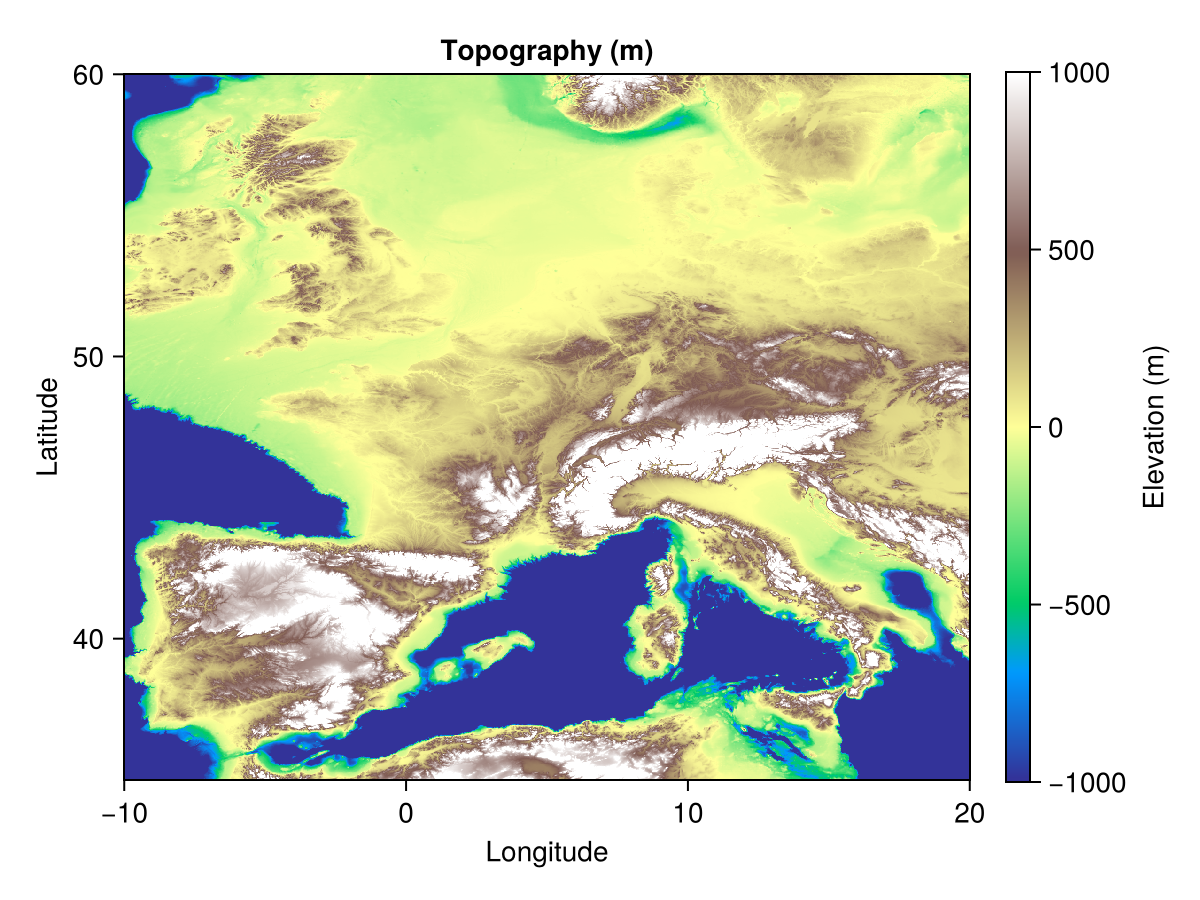

In [123]:


fig, ax, hm = heatmap(
    #topo.x,topo.y,topo.z';
    topoEuro.x,topoEuro.y,topoEuro_surface';
    colormap = :terrain,
    colorrange=(-1000,1000),
    axis = (aspect = DataAspect(), xlabel = "Longitude", ylabel = "Latitude", title = "Topography (m)")
)
Colorbar(fig[1,2], hm, label="Elevation (m)")
fig

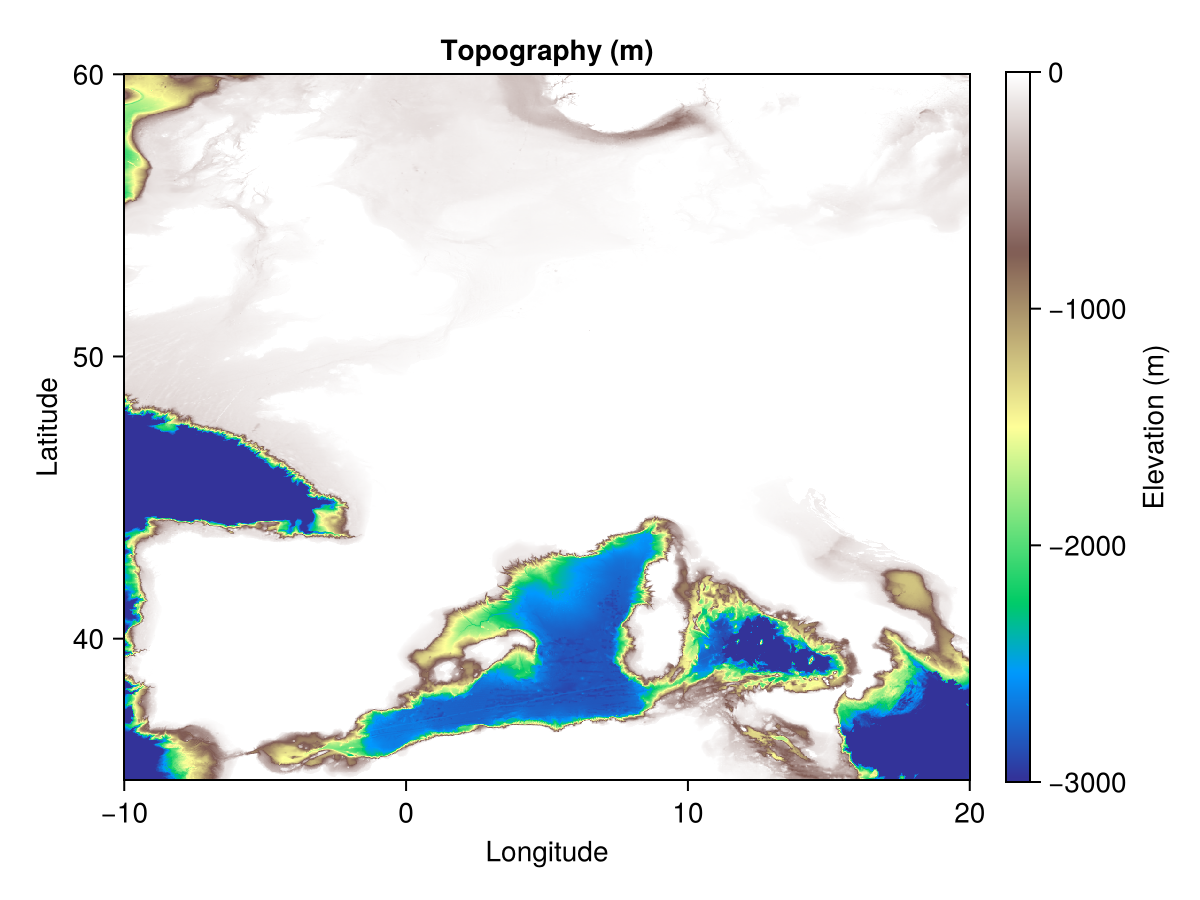

In [124]:


fig, ax, hm = heatmap(
    #topo.x,topo.y,topo.z';
    topoEuro.x,topoEuro.y,topoEuro_bathymetry';
    colormap = :terrain,
    colorrange=(-3000,0),
    axis = (aspect = DataAspect(), xlabel = "Longitude", ylabel = "Latitude", title = "Topography (m)")
)
Colorbar(fig[1,2], hm, label="Elevation (m)")
fig

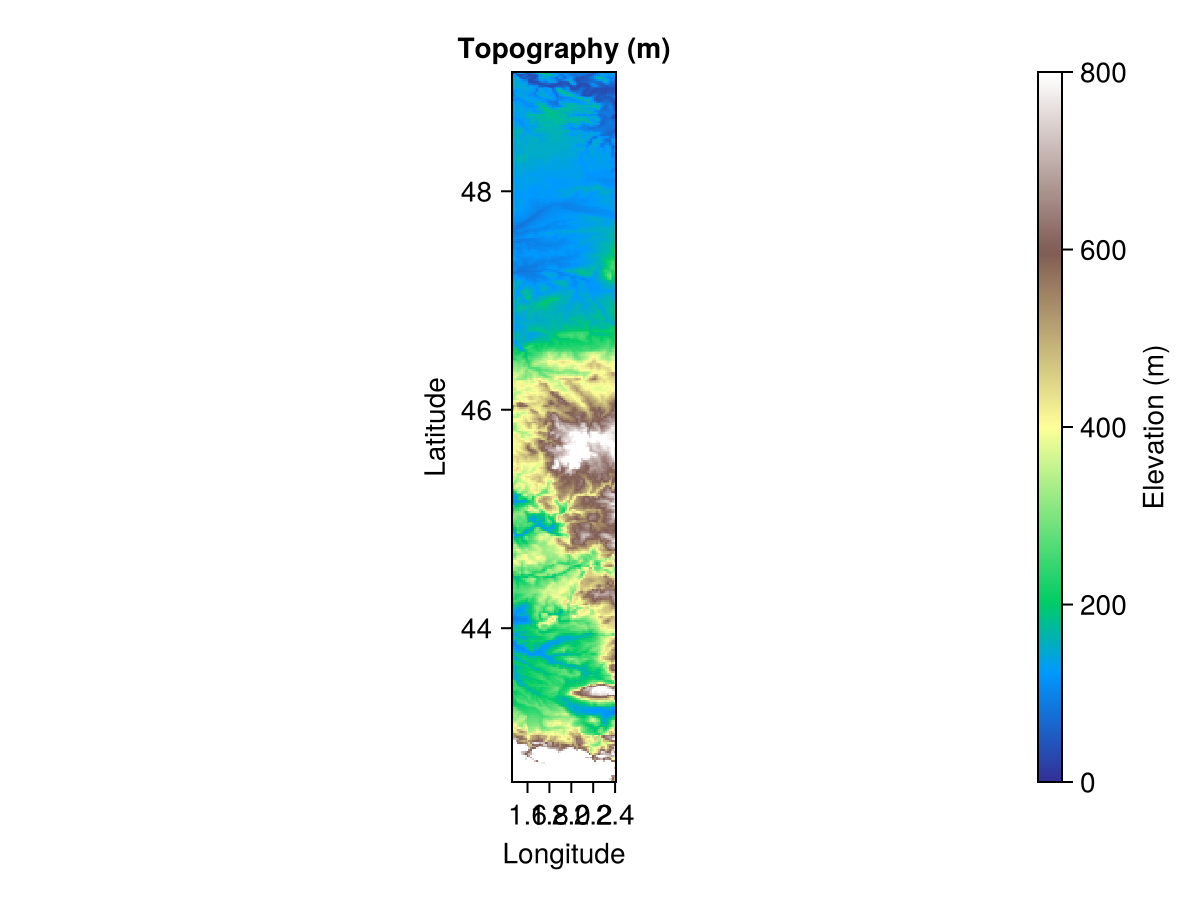

In [125]:
using GMT,CairoMakie

region = [lon_min, lon_max, lat_min, lat_max]

precision = "@earth_relief_01m"
# resolution can be @earth_relief_01m (≈2 km), @earth_relief_03m, or coarser like 10m, 30m, etc.
topo = GMT.grdcut(precision, region=region)
topo_surface = copy(topo.z)
topo_bathymetry = copy(topo.z)
fig, ax, hm = heatmap(
    topo.x,topo.y,topo.z';
    colormap = :terrain,
    colorrange=(0,800),
    axis = (aspect = DataAspect(), xlabel = "Longitude", ylabel = "Latitude", title = "Topography (m)")
)
Colorbar(fig[1,2], hm, label="Elevation (m)")
fig

In [126]:
topo.y

390-element Vector{Float64}:
 42.6
 42.61666666666667
 42.63333333333333
 42.65
 42.66666666666667
 42.68333333333334
 42.7
 42.71666666666667
 42.733333333333334
 42.75
  ⋮
 48.95000000000001
 48.966666666666676
 48.98333333333334
 49.00000000000001
 49.01666666666667
 49.033333333333346
 49.05000000000001
 49.06666666666668
 49.08333333333334

In [127]:
# First we take care of topo_surface

topoInterpolater = interpolate((topo.y,topo.x),topo_surface,Gridded(Linear()));

In [128]:
eps = 100.0 # in metre "below" option should be enough but who knows
for iXZ in CartesianIndices(allGridsInGeoPoints)
    tmpPoint = allGridsInGeoPoints[iXZ]
    if 0.0 <= tmpPoint.alt <= topoInterpolater(tmpPoint.lat,tmpPoint.lon) 
        # it might be very time-consuming if we do this for 3D Cartesian points ...
        effectiveRadii[iXZ]=DSM1D.my1DDSMmodel.averagedPlanetRadiusInKilometer*1.e3 - eps
    end
end

In [131]:
# make a regular grid for the necessary radii
NradiusNodes =500 # I don't know how to make this number reasonable
tmpNradiusNodes = NradiusNodes
if NradiusNodes === 1
    tmpNradiusNodes = 1
end

ΔradiusIncrementInKm = (maximum(effectiveRadii)-minimum(effectiveRadii))/(tmpNradiusNodes-1) *1.e-3
linearRadiiInKm =(collect(1:1:NradiusNodes) .- 1)*ΔradiusIncrementInKm .+ minimum(effectiveRadii)*1.e-3

push!(linearRadiiInKm, DSM1D.my1DDSMmodel.averagedPlanetRadiusInKilometer) # here I put the most important discontinuity but maybe I need to add all vmin inside, the order will be sorted so we don't


501-element Vector{Float64}:
 5960.617361368072
 5961.4497832795805
 5962.282205191089
 5963.114627102597
 5963.947049014106
 5964.779470925614
 5965.6118928371225
 5966.444314748631
 5967.276736660139
 5968.109158571648
    ⋮
 6370.168941830179
 6371.001363741688
 6371.833785653196
 6372.666207564705
 6373.498629476213
 6374.331051387721
 6375.16347329923
 6375.995895210738
 6371.0

In [132]:
newRadii,params=DSM1D.compute1DseismicParamtersFromPolynomialCoefficientsWithGivenRadiiArray(DSM1D.my1DDSMmodel,linearRadiiInKm,"below")

([5960.617361368072, 5961.4497832795805, 5962.282205191089, 5963.114627102597, 5963.947049014106, 5964.779470925614, 5965.6118928371225, 5966.444314748631, 5967.276736660139, 5968.109158571648  …  6369.336519918671, 6370.168941830179, 6371.0, 6371.001363741688, 6371.833785653196, 6372.666207564705, 6373.498629476213, 6374.331051387721, 6375.16347329923, 6375.995895210738], (ρ = [3.7368328538199105, 3.735783696471766, 3.734734539123621, 3.7336853817754765, 3.732636224427332, 3.731587067079187, 3.7305379097310425, 3.7294887523828972, 3.728439595034753, 3.7273904376866085  …  2.6, 2.6, 2.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Vpv = [9.187071020436687, 9.182809401771031, 9.178547783105373, 9.174286164439714, 9.170024545774059, 9.1657629271084, 9.161501308442741, 9.157239689777086, 9.152978071111427, 9.148716452445772  …  5.8, 5.8, 5.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Vph = [9.187071020436687, 9.182809401771031, 9.178547783105373, 9.174286164439714, 9.170024545774059, 9.1657629271084, 9

In [133]:
itp_ρ = LinearInterpolation(newRadii.*1.e3,params.ρ; extrapolation_bc=Flat())
# I know that I don't have to copy this for all the parameters, Hesaneh, you can find an elegant way to do this for vpv, vph etc. with one line!

501-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Flat()) with element type Float64:
 3.7368328538199105
 3.735783696471766
 3.734734539123621
 3.7336853817754765
 3.732636224427332
 3.731587067079187
 3.7305379097310425
 3.7294887523828972
 3.728439595034753
 3.7273904376866085
 ⋮
 2.6
 2.6
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [134]:
#seismicModel2D=(ρ=zeros(Float64,Nx,Nz),Vpv=zeros(Float64,Nx,Nz),Vph=zeros(Float64,Nx,Nz),Vsv=zeros(Float64,Nx,Nz),Vsh=zeros(Float64,Nx,Nz),Qμ=zeros(Float64,Nx,Nz),Qκ=zeros(Float64,Nx,Nz),QμPower=zeros(Float64,Nx,Nz),QκPower=zeros(Float64,Nx,Nz),η=zeros(Float64,Nx,Nz))
for iXZ in CartesianIndices(allGridsInGeoPoints)
    seismicModel2D.ρ[iXZ]= itp_ρ(effectiveRadii[iXZ])
end

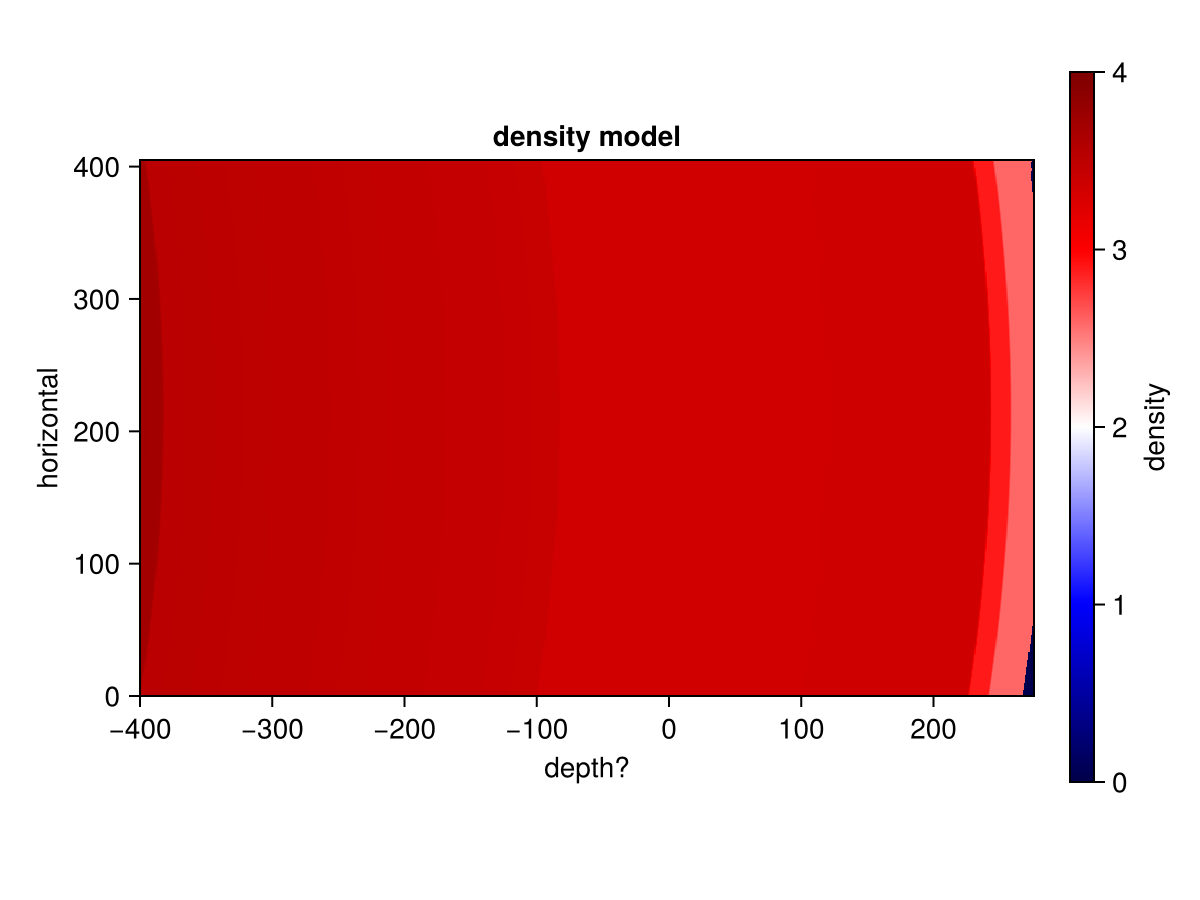

In [141]:
fig, ax, hm = heatmap(
    #topo.x,topo.y,topo.z';
    collect((0:1:(Nx-1)).*Δx.+altMin).*1.e-3,collect(0:1:(Nz-1)).*Δz.*1.e-3, seismicModel2D.ρ';
    colormap = :seismic,
    colorrange=(0,4),
    axis = (aspect = DataAspect(), xlabel = "depth?", ylabel = "horizontal", title = "density model")
)
Colorbar(fig[1,2], hm, label="density")
fig

# I need to do (iii) for the water

In [ ]:
radii,params=DSM1D.compute1DseismicParamtersFromPolynomialCoefficientsWithGivenRadiiArray(DSM1D.my1DDSMmodel,myRadiiArray,"below")
params.Vph

In [ ]:
allGridsInGeoPoints[1,1]

In [ ]:
effectiveRadii[200,1]

In [ ]:
params.ρ

In [ ]:
# resolution can be @earth_relief_01m (≈2 km), @earth_relief_03m, or coarser like 10m, 30m, etc.

# I need to : 
add local coordinates and normals at each point as options to GeoPoint


In [ ]:

# Extract coordinates from GeoPoints
lons = [p.lon for p in allGridsInGeoPoints[:]]
lats = [p.lat for p in allGridsInGeoPoints[:]]


In [ ]:

# Query the topography via grdtrack using the file path
topo_vals = GMT.grdtrack(lons, lats; G=tmpfile,show=false)

In [ ]:


# Reshape back to 2D
Nx, Nz = size(allGridsInGeoPoints)
topo_vals_2D = reshape(topo_vals, Nx, Nz)
